## Create target variables for time series modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy.signal._peak_finding import _boolrelextrema

from functions import *

In [2]:
btc_data = pd.read_parquet('btc_numeric_data.parquet.gzip')
eth_data = pd.read_parquet('eth_numeric_data.parquet.gzip')

### Create differenced price target

In [3]:
btc_targets = pd.DataFrame(index = btc_data.index)
btc_targets['btc_price_absolute_change'] = np.diff(btc_data.btc_price_close, prepend=float('nan'))
btc_targets['btc_price_relative_change'] = ((btc_data.btc_price_close / btc_data.btc_price_close.shift(1)) - 1) * 100
btc_targets['btc_price_log_difference'] = np.diff(np.log(btc_data.btc_price_close), prepend=float('nan'))

In [4]:
eth_targets = pd.DataFrame(index = eth_data.index)
eth_targets['eth_price_absolute_change'] = np.diff(eth_data.eth_price_close, prepend=float('nan'))
eth_targets['eth_price_relative_change'] = ((eth_data.eth_price_close / eth_data.eth_price_close.shift(1)) - 1) * 100
eth_targets['eth_price_log_difference'] = np.diff(np.log(eth_data.eth_price_close), prepend=float('nan'))

### Create binary targets

In [5]:
data = np.array(btc_data.btc_price_close)
btc_targets['btc_price_min_7d'] = _boolrelextrema(data, np.less, order=7) * 1
btc_targets['btc_price_max_7d'] = _boolrelextrema(data, np.greater, order=7) * 1
btc_targets['btc_price_min_14d'] = _boolrelextrema(data, np.less, order=14) * 1
btc_targets['btc_price_max_14d'] = _boolrelextrema(data, np.greater, order=14) * 1
btc_targets['btc_price_min_21d'] = _boolrelextrema(data, np.less, order=21) * 1
btc_targets['btc_price_max_21d'] = _boolrelextrema(data, np.greater, order=21) * 1

In [6]:
data = np.array(eth_data.eth_price_close)
eth_targets['eth_price_min_7d'] = _boolrelextrema(data, np.less, order=7) * 1
eth_targets['eth_price_max_7d'] = _boolrelextrema(data, np.greater, order=7) * 1
eth_targets['eth_price_min_14d'] = _boolrelextrema(data, np.less, order=14) * 1
eth_targets['eth_price_max_14d'] = _boolrelextrema(data, np.greater, order=14) * 1
eth_targets['eth_price_min_21d'] = _boolrelextrema(data, np.less, order=21) * 1
eth_targets['eth_price_max_21d'] = _boolrelextrema(data, np.greater, order=21) * 1

### Visualise time series

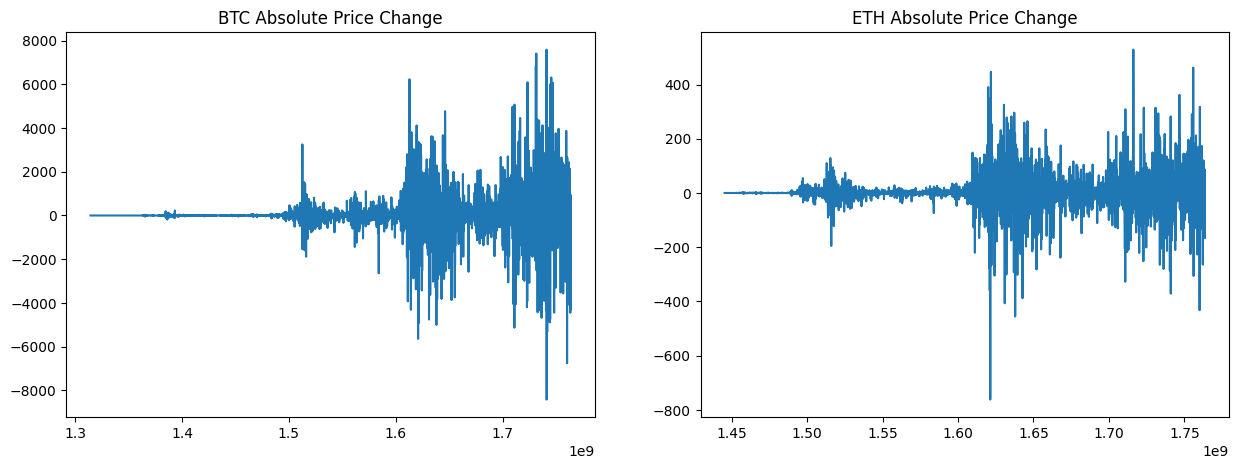

In [7]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(btc_targets.btc_price_absolute_change)
ax[0].set_title('BTC Absolute Price Change')
ax[1].plot(eth_targets.eth_price_absolute_change)
ax[1].set_title('ETH Absolute Price Change')
plt.show()

In [8]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(btc_targets.btc_price_relative_change);
ax[0].set_title('BTC Relative Price Change')
ax[1].plot(eth_targets.eth_price_relative_change);
ax[1].set_title('ETH Relative Price Change')
plt.show()

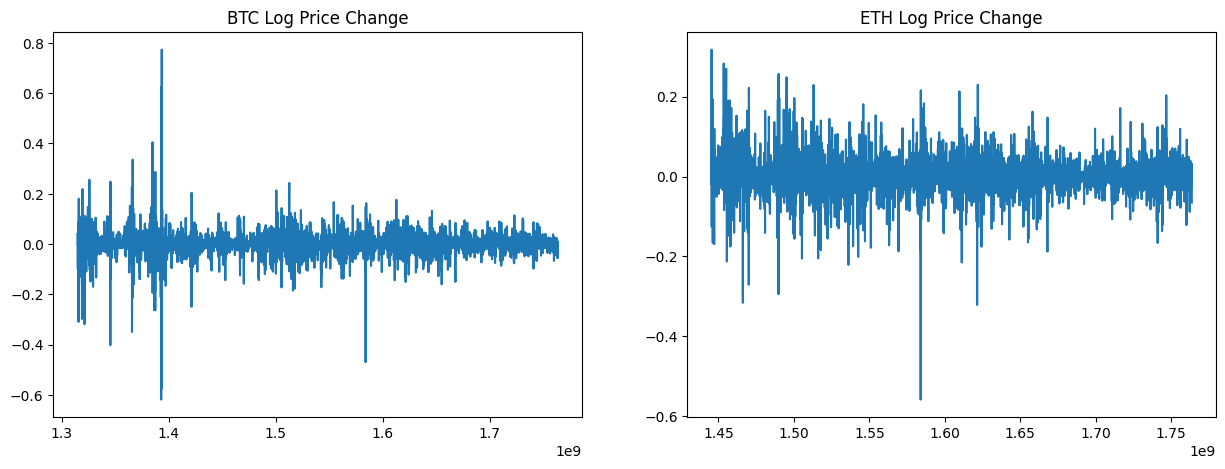

In [9]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(btc_targets.btc_price_log_difference);
ax[0].set_title('BTC Log Price Change')
ax[1].plot(eth_targets.eth_price_log_difference);
ax[1].set_title('ETH Log Price Change')
plt.show()

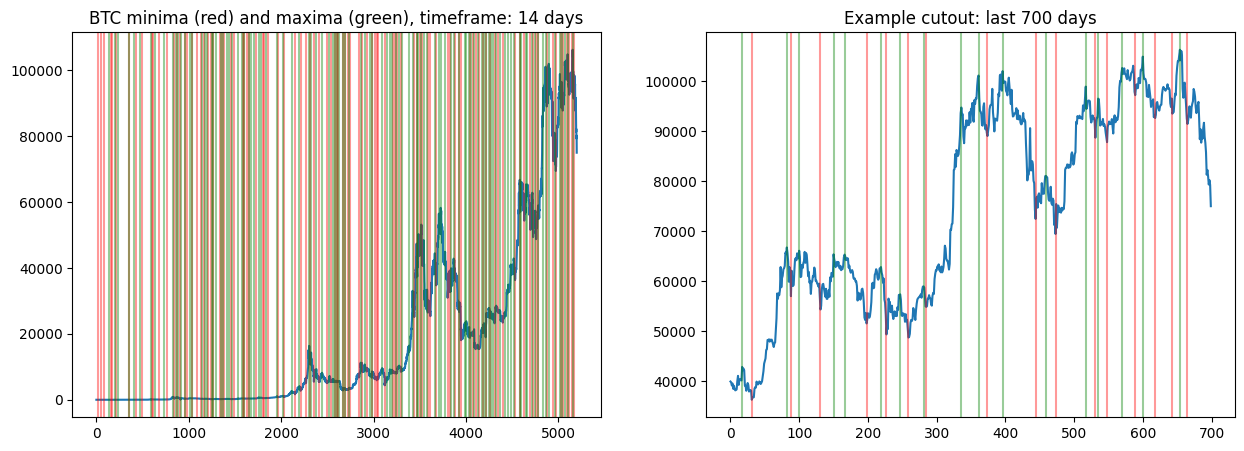

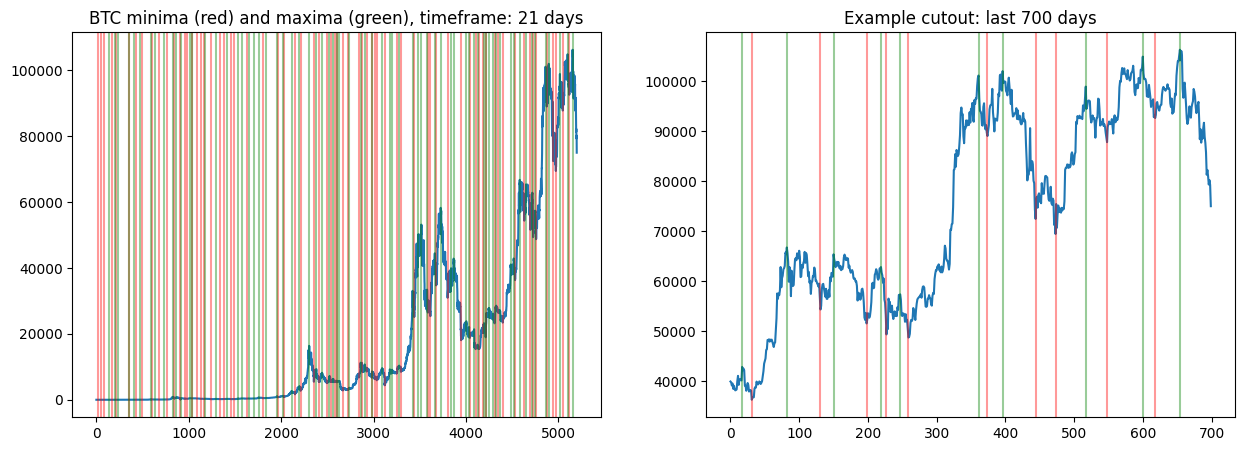

In [10]:
for tf in (7, 14, 21):
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    
    ax[0].plot(btc_data.btc_price_close.reset_index(drop=True))
    for ix in np.nonzero(np.array(btc_targets[f'btc_price_min_{tf}d']))[0]:
        ax[0].axvline(ix, color='r', alpha=.4)
    for ix in np.nonzero(np.array(btc_targets[f'btc_price_max_{tf}d']))[0]:
        ax[0].axvline(ix, color='g', alpha=.4)
    ax[0].set_title(f'BTC minima (red) and maxima (green), timeframe: {tf} days')
    
    tail = 700
    
    ax[1].plot(btc_data.btc_price_close.tail(tail).reset_index(drop=True))
    for ix in np.nonzero(np.array(btc_targets[f'btc_price_min_{tf}d'].tail(tail)))[0]:
        ax[1].axvline(ix, color='r', alpha=.4)
    for ix in np.nonzero(np.array(btc_targets[f'btc_price_max_{tf}d'].tail(tail)))[0]:
        ax[1].axvline(ix, color='g', alpha=.4)
    ax[1].set_title(f'Example cutout: last {tail} days')
    
    plt.show()

### Make visualisation for DSSV slides / Master thesis

In [11]:
plt.rcParams['figure.dpi'] = 700
plt.rcParams['font.family'] = 'Times New Roman'
plt.rc('legend', fontsize=12)
plt.rc('axes', labelsize=14)
plt.rc('axes', titlesize=16)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

tf=21
_, ax = plt.subplots(figsize=(10,5), dpi=500)
ax.plot(btc_data.btc_price_close.tail(tail).reset_index(drop=True),
        label='Bitcoin price')
for ix in np.nonzero(np.array(btc_targets[f'btc_price_min_{tf}d'].tail(tail)))[0]:
    ax.axvline(ix, color='r', alpha=.4)
for ix in np.nonzero(np.array(btc_targets[f'btc_price_max_{tf}d'].tail(tail)))[0]:
    ax.axvline(ix, color='g', alpha=.4)
ax.set_title(f'Sample of BTC extreme points, time frame: +/– {tf} Days',
             pad=10)
ax.set_xlabel('Days', labelpad=5)
ax.set_ylabel('EUR', labelpad=7)
handles, _ = ax.get_legend_handles_labels()
handles.extend([
    Line2D([0], [0], label='Local maxima', color='g', alpha=.3),
    Line2D([0], [0], label='Local minima', color='r', alpha=.3),
])
ax.legend(handles=handles, loc='upper right')
plt.show()

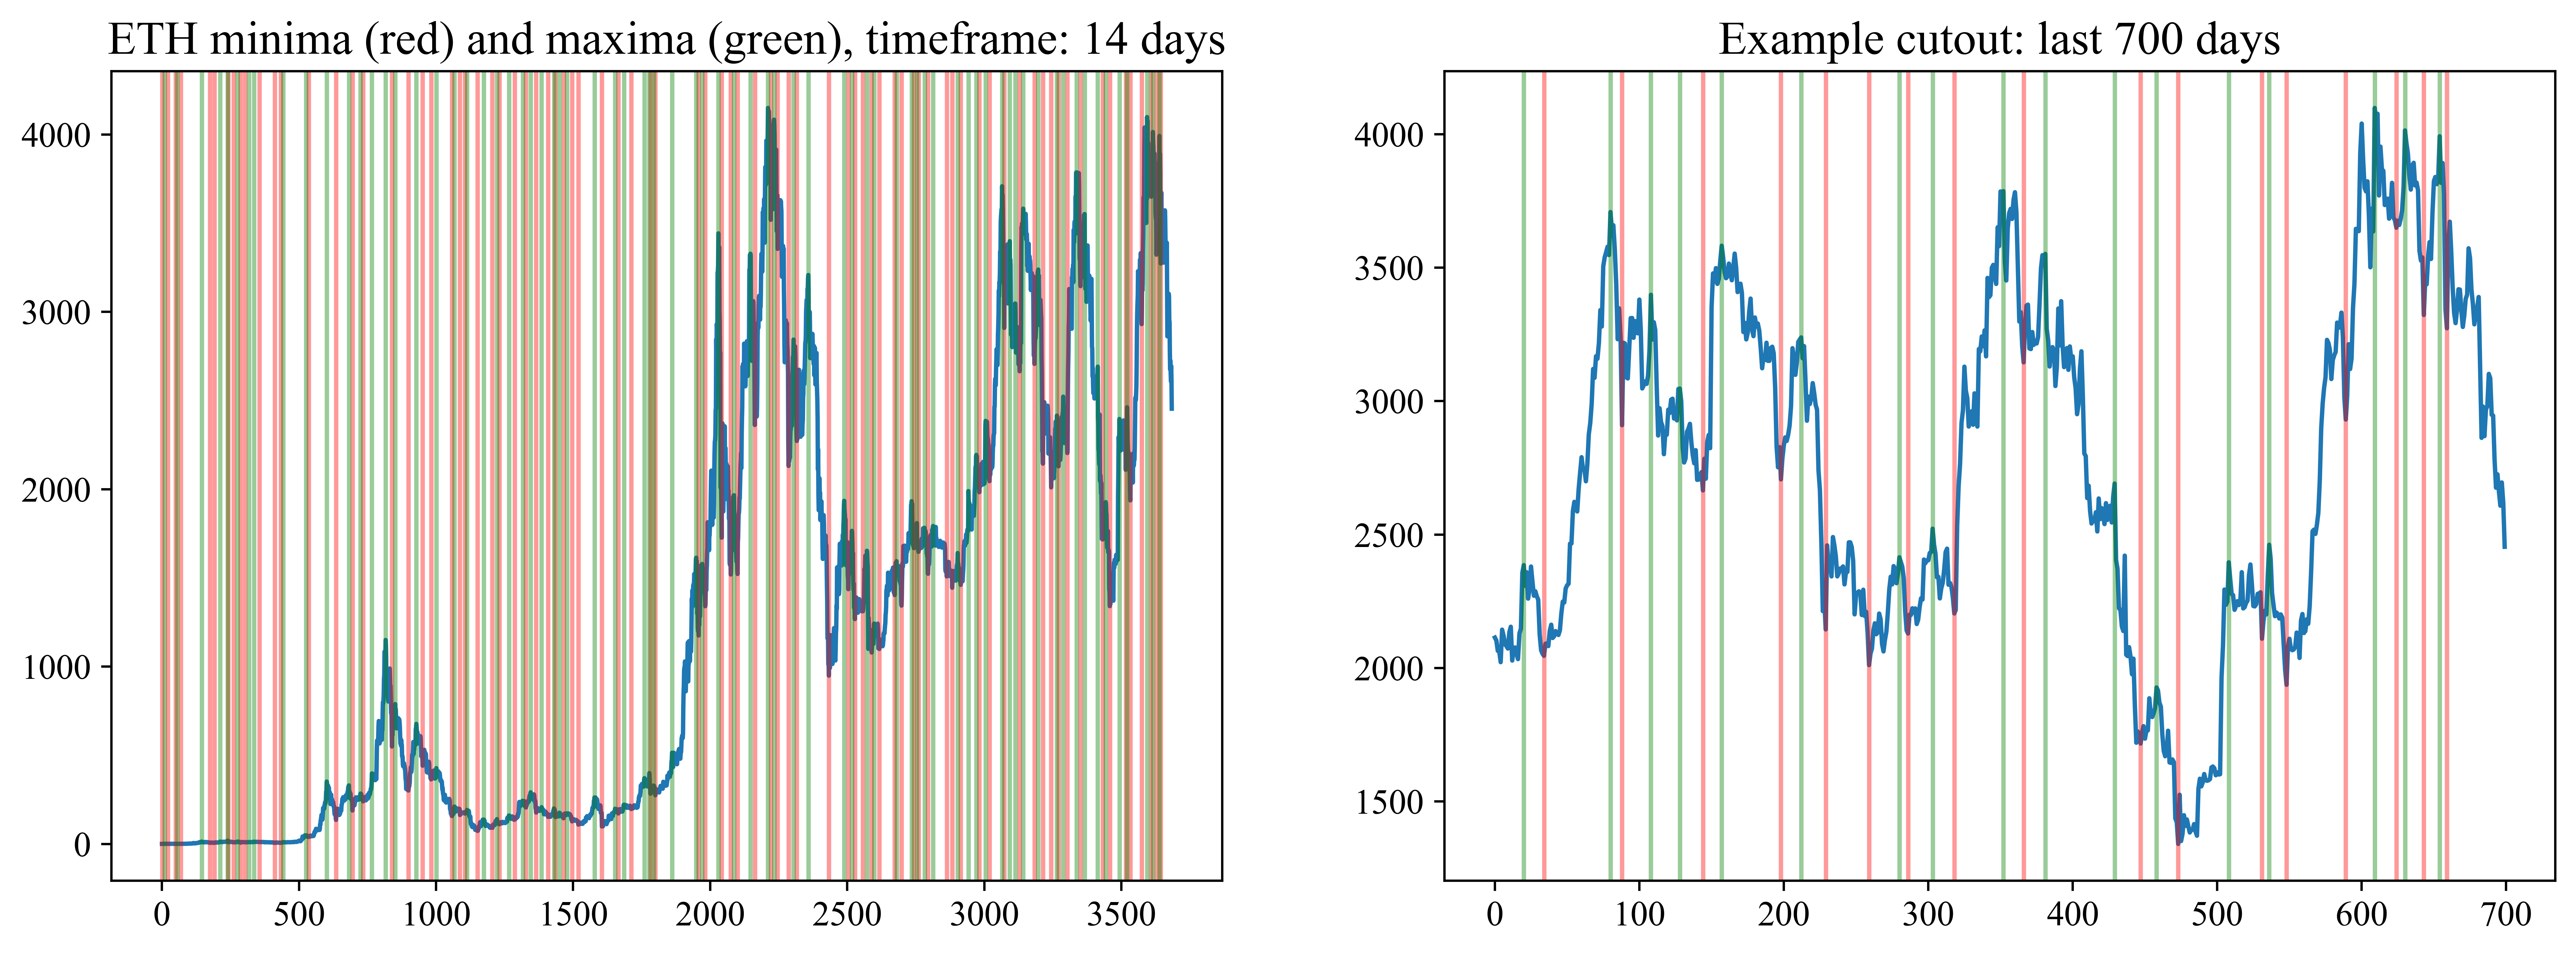

In [12]:
for tf in (7, 14, 21):
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    
    ax[0].plot(eth_data.eth_price_close.reset_index(drop=True))
    for ix in np.nonzero(np.array(eth_targets[f'eth_price_min_{tf}d']))[0]:
        ax[0].axvline(ix, color='r', alpha=.4)
    for ix in np.nonzero(np.array(eth_targets[f'eth_price_max_{tf}d']))[0]:
        ax[0].axvline(ix, color='g', alpha=.4)
    ax[0].set_title(f'ETH minima (red) and maxima (green), timeframe: {tf} days')
    
    tail = 700
    
    ax[1].plot(eth_data.eth_price_close.tail(tail).reset_index(drop=True))
    for ix in np.nonzero(np.array(eth_targets[f'eth_price_min_{tf}d'].tail(tail)))[0]:
        ax[1].axvline(ix, color='r', alpha=.4)
    for ix in np.nonzero(np.array(eth_targets[f'eth_price_max_{tf}d'].tail(tail)))[0]:
        ax[1].axvline(ix, color='g', alpha=.4)
    ax[1].set_title(f'Example cutout: last {tail} days')
    
    plt.show()

### Check stationarity

In [13]:
HeskedTesting.run_all_tests(btc_targets, conf=0.01)

Results of White, Breusch-Pagan and Goldfeld-Quandt tests by column (p-values):

btc_price_absolute_change --   White: 0.0000,      Breusch-Pagan: 0.0000,                             Goldfeld-Quandt: 0.0000
btc_price_relative_change --   White: 0.0000,      Breusch-Pagan: 0.0000,                             Goldfeld-Quandt: 0.0000
btc_price_log_difference --    White: 0.0000,      Breusch-Pagan: 0.0000,                             Goldfeld-Quandt: 0.0000
btc_price_min_7d --            White: 0.2357,      Breusch-Pagan: 0.2371,                             Goldfeld-Quandt: 0.0000
btc_price_max_7d --            White: 0.4722,      Breusch-Pagan: 0.2408,                             Goldfeld-Quandt: 0.0037
btc_price_min_14d --           White: 0.8811,      Breusch-Pagan: 0.6160,                             Goldfeld-Quandt: 0.0009
btc_price_max_14d --           White: 0.1569,      Breusch-Pagan: 0.0636,                             Goldfeld-Quandt: 0.0000
btc_price_min_21d --           White:

In [15]:
HeskedTesting.run_all_tests(eth_targets, conf=0.01)

Results of White, Breusch-Pagan and Goldfeld-Quandt tests by column (p-values):

eth_price_absolute_change --   White: 0.0000,      Breusch-Pagan: 0.0000,                             Goldfeld-Quandt: 0.0000
eth_price_relative_change --   White: 0.0000,      Breusch-Pagan: 0.0000,                             Goldfeld-Quandt: 0.0000
eth_price_log_difference --    White: 0.0000,      Breusch-Pagan: 0.0000,                             Goldfeld-Quandt: 0.0000
eth_price_min_7d --            White: 0.7012,      Breusch-Pagan: 0.4174,                             Goldfeld-Quandt: 0.1540
eth_price_max_7d --            White: 0.8517,      Breusch-Pagan: 0.7131,                             Goldfeld-Quandt: 0.6169
eth_price_min_14d --           White: 0.6163,      Breusch-Pagan: 0.6878,                             Goldfeld-Quandt: 0.3159
eth_price_max_14d --           White: 0.6586,      Breusch-Pagan: 0.4013,                             Goldfeld-Quandt: 0.0241
eth_price_min_21d --           White:

In [14]:
unit_root_testing(btc_targets, conf=0.01)

Results of ADF, PP and KPSS tests by column (p-values):

btc_price_absolute_change --   ADF: 0.0000,        PP: 0.0000,          KPSS: 0.3536
btc_price_relative_change --   ADF: 0.0000,        PP: 0.0000,          KPSS: 0.0395
btc_price_log_difference --    ADF: 0.0000,        PP: 0.0000,          KPSS: 0.2531
btc_price_min_7d --            ADF: 0.0000,        PP: 0.0000,          KPSS: 0.0468
btc_price_max_7d --            ADF: 0.0000,        PP: 0.0000,          KPSS: 0.0603
btc_price_min_14d --           ADF: 0.0000,        PP: 0.0000,          KPSS: 0.8442
btc_price_max_14d --           ADF: 0.0000,        PP: 0.0000,          KPSS: 0.0215
btc_price_min_21d --           ADF: 0.0000,        PP: 0.0000,          KPSS: 0.9821
btc_price_max_21d --           ADF: 0.0000,        PP: 0.0000,          KPSS: 0.4751


In [16]:
unit_root_testing(eth_targets, conf=0.01)

Results of ADF, PP and KPSS tests by column (p-values):

eth_price_absolute_change --   ADF: 0.0000,        PP: 0.0000,          KPSS: 0.9648
eth_price_relative_change --   ADF: 0.0000,        PP: 0.0000,          KPSS: 0.0018
eth_price_log_difference --    ADF: 0.0000,        PP: 0.0000,          KPSS: 0.0117
eth_price_min_7d --            ADF: 0.0000,        PP: 0.0000,          KPSS: 0.2039
eth_price_max_7d --            ADF: 0.0000,        PP: 0.0000,          KPSS: 0.5936
eth_price_min_14d --           ADF: 0.0000,        PP: 0.0000,          KPSS: 0.6914
eth_price_max_14d --           ADF: 0.0000,        PP: 0.0000,          KPSS: 0.4547
eth_price_min_21d --           ADF: 0.0000,        PP: 0.0000,          KPSS: 0.9486
eth_price_max_21d --           ADF: 0.0000,        PP: 0.0000,          KPSS: 0.9953


In [17]:
btc_targets = btc_targets.drop(columns=['btc_price_absolute_change', 'btc_price_relative_change'])
eth_targets = eth_targets.drop(columns=['eth_price_absolute_change', 'eth_price_relative_change'])

### Shift targets back one day and limit timeframe to where all data is available

In [18]:
btc_price_data = btc_targets.loc[1314662400:1763596800][['btc_price_log_difference']]
eth_price_data = eth_targets.loc[1445472000:1763596800][['eth_price_log_difference']]

In [19]:
btc_price_data.to_parquet('btc_price_data.parquet.gzip',
                       compression='gzip')

eth_price_data.to_parquet('eth_price_data.parquet.gzip',
                       compression='gzip')

In [20]:
btc_targets_unshifted = btc_targets.loc[1314662400:1763596800]
eth_targets_unshifted = eth_targets.loc[1445472000:1763596800]

In [21]:
btc_targets_unshifted.to_parquet('btc_targets_unshifted.parquet.gzip',
                                 compression='gzip')

eth_targets_unshifted.to_parquet('eth_targets_unshifted.parquet.gzip',
                                 compression='gzip')


In [22]:
btc_targets = btc_targets.shift(-1).loc[1314662400:1763596800]
eth_targets = eth_targets.shift(-1).loc[1445472000:1763596800]

In [23]:
btc_targets.to_parquet('btc_targets.parquet.gzip',
                       compression='gzip')

eth_targets.to_parquet('eth_targets.parquet.gzip',
                       compression='gzip')